In [1]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
data = pd.read_csv("./유방암.CSV",engine="python")
data.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 no

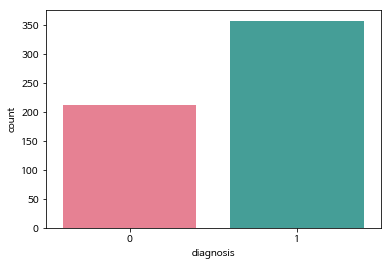

In [2]:
# 결측치 없다.
data.isnull().sum(axis=0)
#데이터 타입 확인
data.info()
# Checking if classes are unbalanced or balanced
data['diagnosis'].value_counts()
# '1' 은 Malignant으로 악성이다 -> 212/(212 + 357) = 0.37 
# '0' 은 Benign으로 양성이다 -> 357/(212+357) = 0.627
sns.countplot(data.diagnosis)
sns.countplot(data['diagnosis'],  palette = "husl")

# 데이터 스케일
- **1. 모든 분포가 왼쪽으로 치우쳐 있기 때문에 로그 변환을 적용해 분포를 보다 정상으로 만들고 왼쪽 꼬리를 중앙으로 sacle한다**

- **2. 전체 데이터를 (0,1)사이의 MinMaxScaler과 평균 0 표준 편차 1 만들어 값을 변화시킨다.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD6D5004E0>,
      dtype=object)

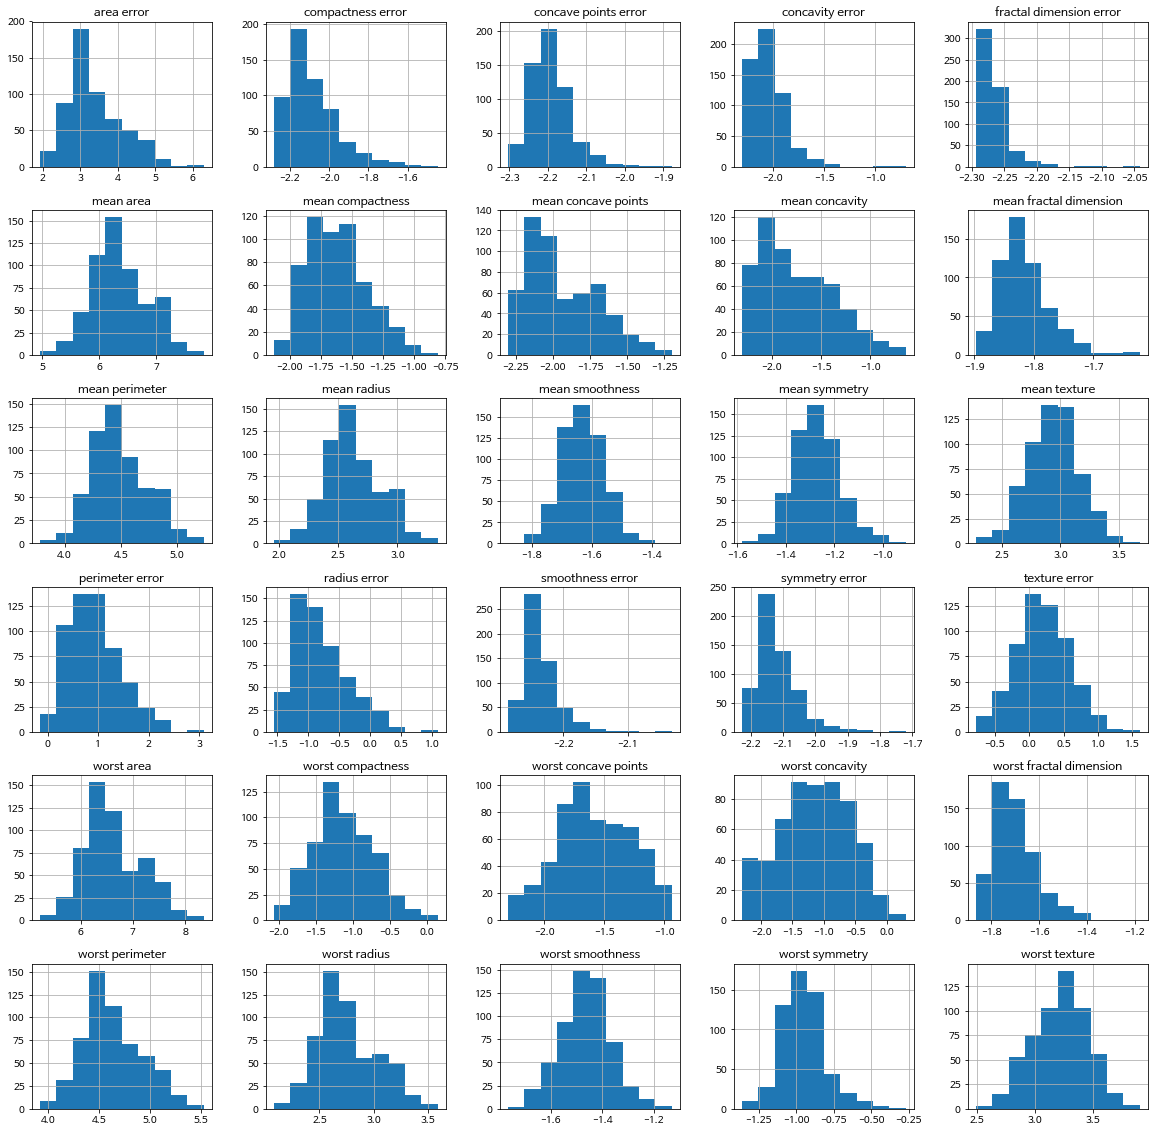

In [3]:
data_x = data.drop("diagnosis",axis=1)
data_y = data["diagnosis"]

X_log = data_x.apply(lambda x: np.log(x + 0.1))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_log)
X_log.hist(figsize = (20,20))

# 데이터 분할 (train, test 데이터 7:3)
- Data set을 train과 test로 나누고 초기화한다

In [4]:
# 데이터 분할(train, test 데이터 7:3으로 - numpy->random)
np.random.seed(seed=1234)

# 0.7보다 작으면 True -> train 데이터, 아니면 False -> test 데이터
msk = np.random.rand(data.shape[0]) < 0.7
data_train = data[msk]
data_test = data[~msk]

# train/test 데이터의 목표변수/설명변수 지정
data_train_y = data_train["diagnosis"]
data_train_x = data_train.drop("diagnosis", axis=1, inplace=False)
data_test_y = data_test["diagnosis"]
data_test_x = data_test.drop("diagnosis", axis=1, inplace=False)

# train데이터와 test데이터 크기
print("train data X size: {}".format(data_train_x.shape))
print("train data Y size: {}".format(data_train_y.shape))
print("test data X size: {}".format(data_test_x.shape))
print("test data Y size: {}".format(data_test_y.shape))

# train data: 385, test data: 184

train data X size: (385, 30)
train data Y size: (385,)
test data X size: (184, 30)
test data Y size: (184,)


# 랜덤포레스트 정확도 비교
- Training set : 1.0
- Test set : 0.967

In [5]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(data_train_x, data_train_y)

# 훈련 데이터 정확도
print("Accuracy on training set:{:.3f}".format(rf_uncustomized.score(data_train_x,
                                                                      data_train_y)))
print("Accuracy on training set:{:3f}".format(rf_uncustomized.score(data_test_x,
                                                                      data_test_y)))

Accuracy on training set:1.000
Accuracy on training set:0.967391


# tree model 옵션 확인

In [6]:
rf_uncustomized.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)>

# GridSearchCV 사용
- **CRiterion: 분리 기준 변경(gini, entropy)**
- **depth는 1~50까지 잡는다. (tree - 최대 깊이)**
- **n_estimators는 5~20**
- **min_samples_split는 2~5**
- **GridSearchCV.fit 저장**

In [7]:
depths = np.arange(1,51)
n_estimators = [5,6,7,8,9,10,11,12,15,20]
min_samples_split = [2,3,4,5]
para_criterion = ["gini", "entropy"]
param_grid = [{'criterion' : para_criterion,'n_estimators':n_estimators, 'max_depth': depths, 'min_samples_split':min_samples_split}]

tree_GS = RandomForestClassifier(random_state=1234)
gs = GridSearchCV(estimator=tree_GS, param_grid=param_grid,cv=10)
gs = gs.fit(data_train_x,data_train_y)
gs

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'criterion': ['gini', 'entropy'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 15, 20], 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]), 'min_samples_split': [2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
 

# GridSearch 출력
- **GridSearch를 했을 때 가장좋은 test accuracy중 가장 좋은 score를 출력**
- **그 때 조합들의 parameter를 출력했다.**

In [8]:
print(gs.best_score_)
print(gs.best_params_)

0.9584415584415584
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 11}


In [9]:
my_model = gs.best_estimator_
my_model.fit(data_train_x,data_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

# GridSearch로 추출한 Parameter 설정 
- **DecisionTree의 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 11로 설정**
- **imporatnce가 높은 순서대로 출력했다.**

In [10]:
# 최종 모델
rf_model = RandomForestClassifier(criterion="gini", max_depth=5,min_samples_split=4,n_estimators=11,random_state=1234)
rf_model.fit(data_train_x,data_train_y)
# rf_model.featrue_importance_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = data_train_x.columns
ds_feature_importance["importance"] = rf_model.feature_importances_
ds_feature_importance.sort_values(by="importance",ascending=False)


,feature,importance
27,worst concave points,0.177678
7,mean concave points,0.158377
22,worst perimeter,0.157157
3,mean area,0.129696
2,mean perimeter,0.056929
0,mean radius,0.051786
5,mean compactness,0.040550
6,mean concavity,0.026173
21,worst texture,0.025066
20,worst radius,0.023488


# 설명변수 중요도 그래프 표현
- **worst concave points, worst perimeter, mean concave points, mean area가 유의한 변수 순서로보였다.**
- **0 - 전혀 사용되지 않음, 1- 완벽하게 타겟의 클래스를 예측했다고 해석 가능**
- **값이 낮다고해서 설명변수가 유용하지 않다는 뜻은 아니다.**
- **단지 트리가 그 변수를 선택하지 않았을 뿐이며, 다른 설명변수가 동일한 정보를 지니고 있을가능성이 있다.**

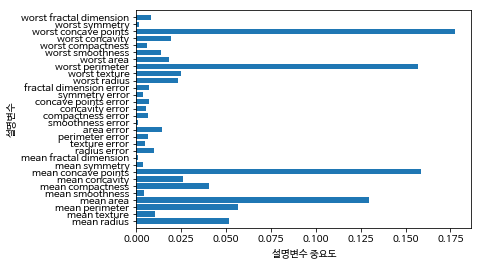

In [11]:
def plot_feature_importances(model):
    n_feature = data_train_x.shape[1]
    plt.barh(range(n_feature),model.feature_importances_,align="center")
    plt.yticks(np.arange(n_feature), data_train_x.columns)
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1, n_feature)
# 설명변수 중요도 그리는 함수 실행
plot_feature_importances(rf_model)
    